# Style Transfer

Adapted from: https://pytorch.org/tutorials/advanced/neural_style_tutorial.html

In [11]:
import torch
import torch.nn as nn
from torchvision.transforms.functional import pil_to_tensor, to_pil_image
import torchvision.transforms as transforms

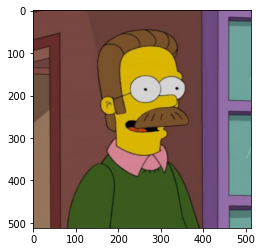

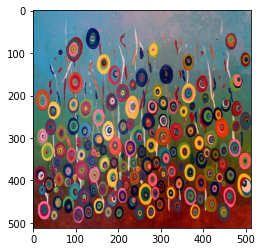

In [12]:
from io import BytesIO
import requests
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Loads image from url
def load_image_from_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    return img

def show_img(img):
    plt.figure()
    img = transforms.ToPILImage()(img.detach().cpu()[0])
    plt.imshow(img)
    plt.show()

img_original = Image.open("ned_flanders.jpg")
img_style = load_image_from_url('https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.wassilykandinsky.net%2Fimages%2Fworks%2F540.jpg&f=1&nofb=1&ipt=a5a06a9bf6e0e544950317f567b6967489504554afd9c16d37dd827c1817f67c&ipo=images')
img_style = load_image_from_url('https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fimages.fineartamerica.com%2Fimages%2Fartworkimages%2Fmediumlarge%2F3%2Fmy-flowers-smell-like-kandinsky-susan-wilkinson.jpg&f=1&nofb=1&ipt=f8b1f07cfe903e77b854d4b3c74545c27da897a9b273f93fbd74c2033eca767c&ipo=images')

loader = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
])

img_original = loader(img_original).unsqueeze(0).to(device, torch.float)
img_style = loader(img_style).unsqueeze(0).to(device, torch.float)

show_img(img_original)
show_img(img_style)

In [13]:
from torchvision.models import vgg19

model = vgg19(pretrained=True)
model = model.to(device)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [14]:
import torch.nn.functional as F

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super().__init__()

        self.mean = torch.tensor(mean).view(-1, 1, 1).to(device)
        self.std = torch.tensor(std).view(-1, 1, 1).to(device)

    def forward(self, x):
        return (x - self.mean) / self.std

class ContentLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = target.detach()
    
    def forward(self, x):
        # self.loss = nn.MSELoss()(x, self.target)
        self.loss = F.mse_loss(x, self.target)
        return x

class StyleLoss(nn.Module):
    def __init__(self, target):
        super().__init__()
        self.target = self.gram_matrix(target).detach()

    def gram_matrix(self, x):
        a, b, c, d = x.size()
        m = x.view(a * b, c * d)
        gram = torch.mm(m, torch.transpose(m,0,1))
        normalized = gram.div(a * b * c * d)
        return normalized

    def forward(self, x):
        # self.loss = nn.MSELoss()(self.gram_matrix(x), self.target)
        self.loss = F.mse_loss(self.gram_matrix(x), self.target)
        return x

In [15]:
type_to_name = {
    nn.Conv2d: "conv_{}",
    nn.ReLU: "relu_{}",
    nn.MaxPool2d: "pool_{}",
    nn.BatchNorm2d: "bn_{}",
}

model_features = model.features.to(device).eval()

content_layers = ["conv_4"]
style_layers = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

style_losses = []
content_losses = []

final_model = nn.Sequential(
    Normalization(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).to(device)
)

i = 0
for layer in model_features.children():
    layer_name = ""
    for type, name in type_to_name.items():
        layer_name = name.format(i)
        if isinstance(layer, type):
            if type == nn.Conv2d:
                i += 1
            if type == nn.ReLU:
                final_model.add_module(name.format(i), nn.ReLU(inplace=False).to(device))
                break
            else:
                layer_name = name.format(i)
                final_model.add_module(name.format(i), layer)
                break

    if layer_name in content_layers:
        content_loss = ContentLoss(final_model(img_original).detach()).to(device)
        final_model.add_module("content_loss_{}".format(i), content_loss)
        content_losses.append(content_loss)
        content_layers.remove(layer_name)

    if layer_name in style_layers:
        style_loss = StyleLoss(final_model(img_style).detach()).to(device)
        final_model.add_module("style_loss_{}".format(i), style_loss)
        style_losses.append(style_loss)
        style_layers.remove(layer_name)

    if len(style_layers) == 0 and len(content_layers) == 0:
        break

final_model.add_module("sigmoid", nn.Sigmoid().to(device))

final_model = final_model.to(device)
final_model


Sequential(
  (0): Normalization()
  (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_1): StyleLoss()
  (relu_1): ReLU()
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_2): StyleLoss()
  (relu_2): ReLU()
  (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_3): StyleLoss()
  (relu_3): ReLU()
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (content_loss_4): ContentLoss()
  (style_loss_4): StyleLoss()
  (relu_4): ReLU()
  (pool_4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (style_loss_5): StyleLoss()
  (sigmoid): Sigmoid()
)

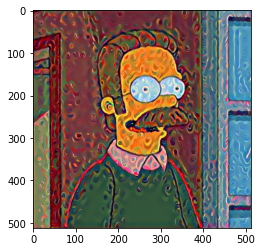

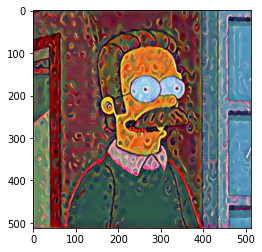

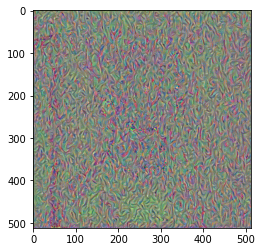

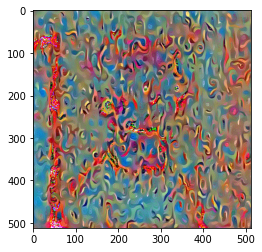

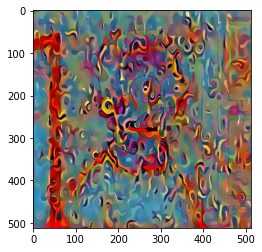

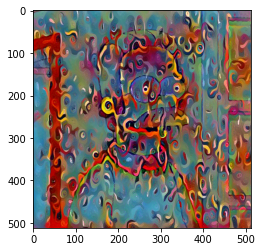

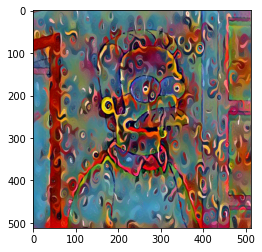

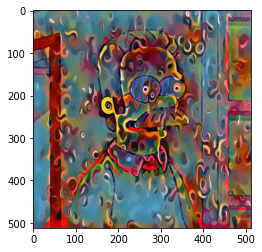

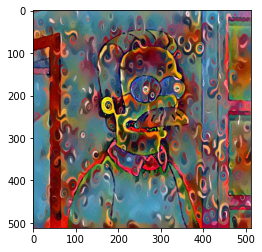

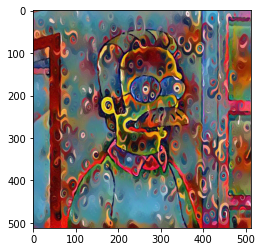

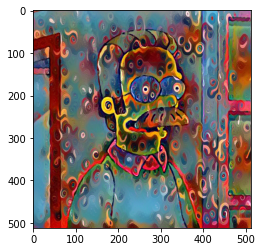

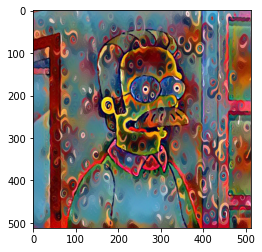

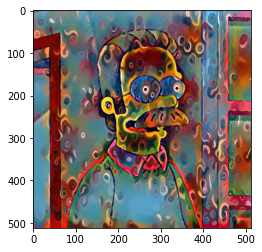

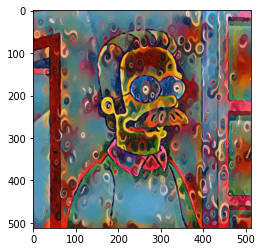

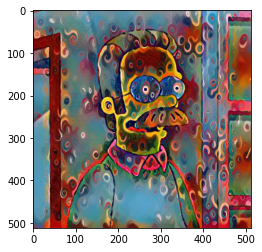

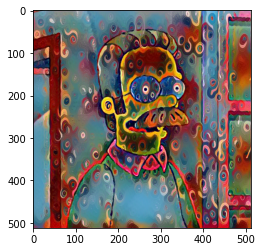

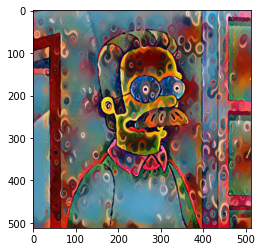

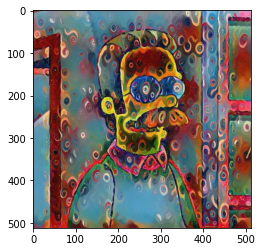

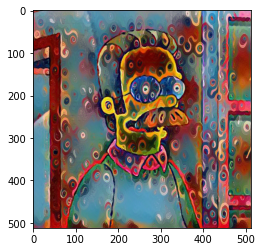

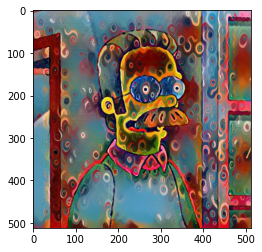

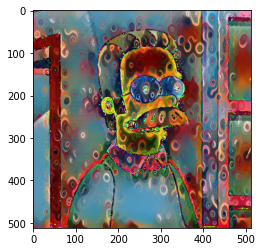

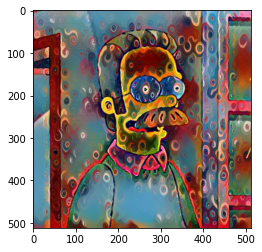

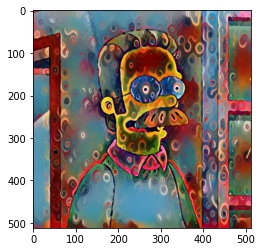

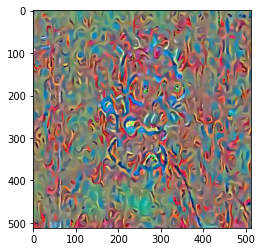

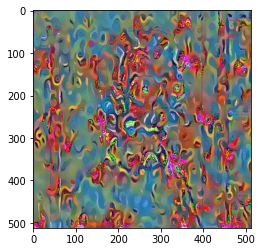

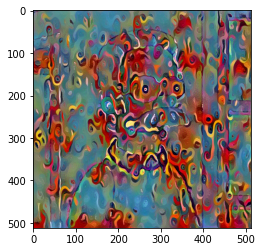

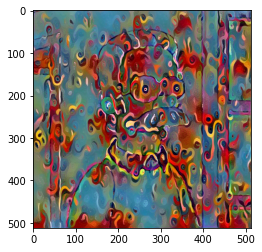

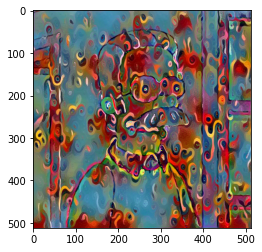

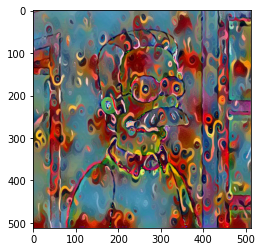

In [16]:
import numpy as np

img_input = img_original.clone()
img_input.requires_grad_(True)
final_model.requires_grad_(False)
optimizer = torch.optim.LBFGS([img_input], lr=0.5)

torch.autograd.set_detect_anomaly(True)

generated_imgs = []

def optimizer_step():
    with torch.no_grad():
        img_input.clamp_(0, 1)

    optimizer.zero_grad()
    final_model(img_input)

    style_loss = 0
    for sl in style_losses:
        style_loss += sl.loss
    style_loss *= 1000000.0

    content_loss = 0
    for cl in content_losses:
        content_loss += cl.loss
    content_loss *= 1.0

    loss = style_loss + content_loss
    loss.backward()

    # print('style loss: {:.4f} content loss: {:.4f}'.format(style_loss.item(), content_loss.item()))
    return style_loss + content_loss

for i in range(1, 300):
    optimizer.step(optimizer_step)
    generated_imgs.append(img_input.clone().detach().cpu().squeeze(0))
    if i % 10 == 0:
        show_img(img_input)


In [18]:
from IPython.display import Video
import imageio

to_pil = transforms.ToPILImage()
images = [ to_pil(img) for img in generated_imgs ]
imageio.mimsave('generated.mp4', images, fps=10)
Video("generated.mp4", width=400, height=400)

